In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(FNN)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(GenomicRanges)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object i

In [2]:
lmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", 
                  sep = "\t", row.names = 1)

In [3]:
hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
hrange <- GenomicRanges::GRanges(hg38[, 1], IRanges::IRanges(as.integer(hg38[, 2]), as.integer(hg38[, 3])))

In [4]:
### Add brain region color
cols <- read.csv("/projects//ps-renlab2/y2xie/projects/BICAN/ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [5]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [6]:
bcol <- read.csv("../Figure/superterm.color", row.names = 1, sep = "\t")
ccol3 <- bcol$bcol
names(ccol3) <- rownames(bcol)

dcol <- c("#8ecae6", "#00acdf", "#006699")
names(dcol) <- unique(lmeta$donor)

tcol <- c("#2EA7E0", "#956134")
names(tcol) <- c("H3K27ac", "H3K27me3")

In [7]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

In [8]:
glut <- lmeta %>% filter(structure == "Cortex", class == "Glut") %>% select(subclass_corrected) %>% unique %>%
unlist %>% as.character
gaba <- lmeta %>% filter(structure == "Cortex", class == "GABA") %>% select(subclass_corrected) %>% unique %>%
unlist %>% as.character
nonn <- lmeta %>% filter(structure == "Cortex", class == "NonN") %>% select(subclass_corrected) %>% unique %>%
unlist %>% as.character

In [9]:
### restrict fov to analyze
goodfov <- read.table("quan_cortex_annotated.11.20.2025.goodfov", sep = "\t")
goodfov <- goodfov$x

## Read integrated objects

In [44]:
obj <- readRDS("quan_cortex_annotated.11.20.2025_MiniAtlas_integration.rds")
obj

An object of class Seurat 
73446 features across 506153 samples within 2 assays 
Active assay: SCT (34971 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, integrated.dr, umap, integrated.cca, umap50

In [23]:
mmg <- readRDS("quan_cortex_annotated.11.20.2025.rds")
mmg

An object of class Seurat 
988 features across 729222 samples within 2 assays 
Active assay: Spatial (959 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: niche
 3 dimensional reductions calculated: ucsd_pca, ucsd_harmony, ucsd_harmony_umap
 20 spatial fields of view present: UCI4723Q02A38 UCI2424Q02A38 UWA7648Q02A38 UCI5224Q02A38 UCI4723Q04PPHC UCI5224Q04PPHC UWA7648Q04PPHC UCI2424Q04PPHC UCI4723Q06Ig UCI5224Q06Ig UCI2424Q06Ig UWA7648Q06Ig UCI2424Q02PSC1 UCI4723Q02PSC1 UCI5224Q02PSC1 UWA7648Q02PSC1 UCI4723Q06PSC2 UWA7648Q06PSC2 UCI2424Q06PSC2 UCI5224Q06PSC2

In [72]:
exprr <- AverageExpression(mmg, assay = 'Spatial', group.by = 'pred_layer')$Spatial %>% as.matrix
dim(exprr)

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


[1] 959   7

In [82]:
clist <- list()
for (i in 1:nrow(exprr)){
    clist[[i]] <- cor(exprr[i,], 1:7, method = "spearman")
}

result <- data.frame(cor = unlist(clist), gene = rownames(exprr))

In [91]:
qgene <- result %>% filter(cor > 0.9) %>% select(gene) %>% unlist %>% as.character

exprr[qgene, ]

L2         L23        L4          L5          L56         L6        
GRN        18.2684452 18.7490473  19.0059802  20.3472321  20.7894844  20.986687
LUC7L2      0.9077882  0.9495311   0.9638801   0.9866631   1.0485914   1.098183
SRBD1       4.0380371  4.2600833   4.3630856   4.3735300   4.7194420   4.834612
ANLN        1.4155159  1.9268037   2.6297582   2.6105330   3.3347979   4.267675
ST18        0.7223588  0.9373657   1.1592845   1.3626883   1.5426906   1.749896
TMEM144     4.9803240  9.0456449  15.5847444  21.9227364  21.2502783  30.546204
ENPP6       0.6908603  0.7830748   0.8524039   0.9560502   0.9780476   1.391671
CLMN        8.6735696 11.4908498  17.0812434  18.6479741  26.5817670  18.898562
ARAP2      15.0312015 16.8127607  18.9602269  19.4128511  21.7615989  24.946382
SH3PXD2B    7.5352608  7.6260686   7.8446022   8.3181321  10.0027218   8.469244
SPAST       5.8753356  6.0584999   6.3324313   6.9494783   6.3834153   7.979402
ABCA2      73.6788461 88.6959895 111.0235431 120.7176272 152.2352670 150.927007
ZNF536      4.2314681  5.1725139   5.6213941   6.0101921   8.4534510   7.858910
SPOCK3      8.6419641 10.1400145  12.5268035  15.4563800  14.1504946  22.258121
CNDP1       1.6523583  5.5440879  12.9911917  15.2550096  15.5528718  15.344138
CDK18      12.4276619 19.3626680  38.3803166  43.9111983  40.6765196  45.824123
COL4A5      2.1201469  2.3468837   2.2093401   2.4988858   2.9101189   3.359431
NKAIN2      4.9909510  5.2345136   7.9081641  12.6219704  12.6981742  16.546281
NKX6-2      2.7096193  4.6933038   8.9722494  11.2846239  15.4202901  25.881155
UNC5B       7.7970798  9.4561222   9.6147758   9.6311418   9.7446483  11.147959
TLE4        1.0935808  1.3434363   1.4778136   1.6747287   1.8694455   2.302304
MOG         4.0107161  8.5757646  16.9285557  23.4551145  41.8488719  34.582281
SFRP1       1.3718206  1.4967056   1.5390113   1.8530359   1.7495075   3.000202
RNF14      10.7894462 10.9637491  11.2033530  12.5129548  14.8421653  13.213832
LRRC8D      5.7819465  6.4475394   7.1960215   7.9745575   7.3986168   8.276267
SOX10      26.0716324 31.7419008  37.0837968  50.6506471  67.0095258  62.299492
MRPL48      2.6693566  2.5965245   2.7185582   2.9892636   3.0305940   3.205532
ZEB2       34.5803878 40.6313168  44.8270902  49.3006066  52.8103017 116.367206
ABCA8       1.0957896  1.4179222   1.8965267   2.4750061   2.7485982   3.102003
CTNNA3      1.6543276  3.0739137   5.2226766   5.6807225   5.6602337  21.473977
CPPED1      2.7314788  3.2147943   3.6684150   3.8539170   3.8776796   4.673546
FIBCD1      0.6455221  0.7143860   0.6833953   0.8026458   1.6907849   1.523264
CDC42BPA   19.0482414 20.8694817  23.6156566  22.7449699  24.3578934  24.588665
ARHGEF2    28.5118326 32.4006846  35.7713518  36.5197866  43.0809629  40.532476
SLC5A11     0.9659603  1.8453289   4.6052506   4.7802274  14.2040958   5.583041
CPAMD8      1.6341683  1.6528298   1.8175331   1.8934037   1.8832932   3.163094
AL359091.1  4.0053129 10.8392331  20.3762363  21.8189741  40.6750982  26.696201
UNC5C       5.9372782  7.4912378   9.7503211  10.0011528  14.0957771  11.698701
OPALIN      4.1825203  8.3193056  14.3922382  20.6192840  17.6334545  43.036950
CECR2       1.5954016  1.7720698   1.7831755   2.2810589   1.9960314   2.562028
AC008571.2  0.4968293  0.5596806   0.7301896   0.9071088   1.0842626   1.287323
           White-matter
GRN         21.581955  
LUC7L2       1.970876  
SRBD1        6.331590  
ANLN        13.830103  
ST18         4.459771  
TMEM144    100.617483  
ENPP6        6.181380  
CLMN        44.145756  
ARAP2       49.975038  
SH3PXD2B    12.395250  
SPAST       11.160173  
ABCA2      326.527770  
ZNF536      21.052585  
SPOCK3      61.530749  
CNDP1       42.325030  
CDK18      123.404878  
COL4A5       5.958755  
NKAIN2      30.889861  
NKX6-2      67.846357  
UNC5B       19.714537  
TLE4         3.334081  
MOG        124.848630  
SFRP1        6.509131  
RNF14       16.565707  
LRRC8D      17.275351  
SOX10      155.076764  
MRP

Warning message:
“annotation$theme is not a valid theme.
Please use `theme()` to construct themes.”
Warning message:
“annotation$theme is not a valid theme.
Please use `theme()` to construct themes.”


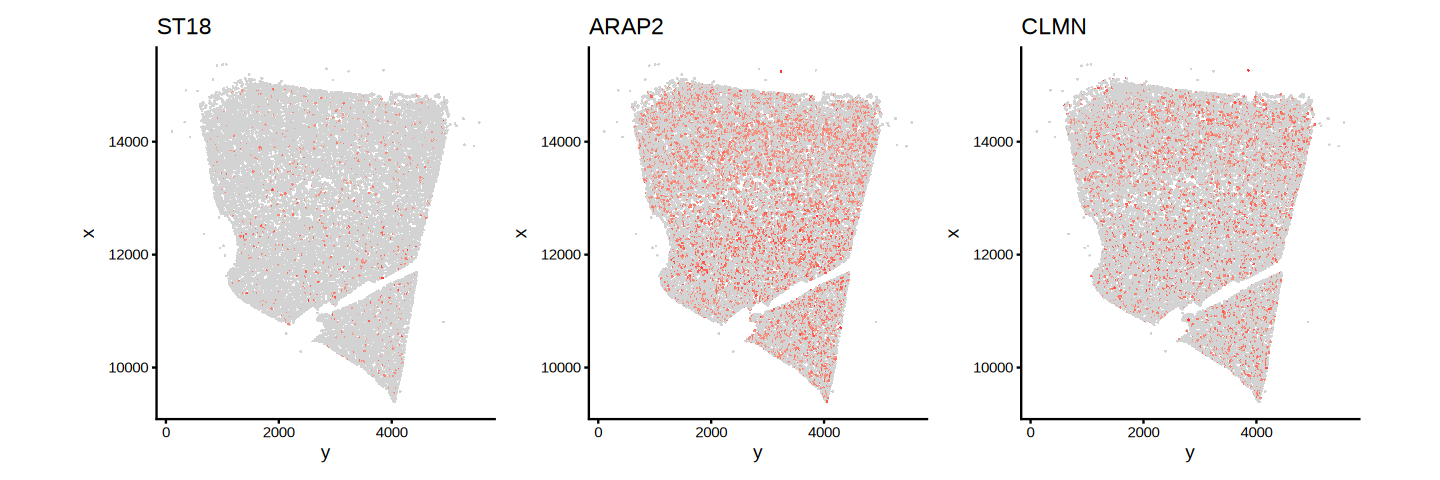

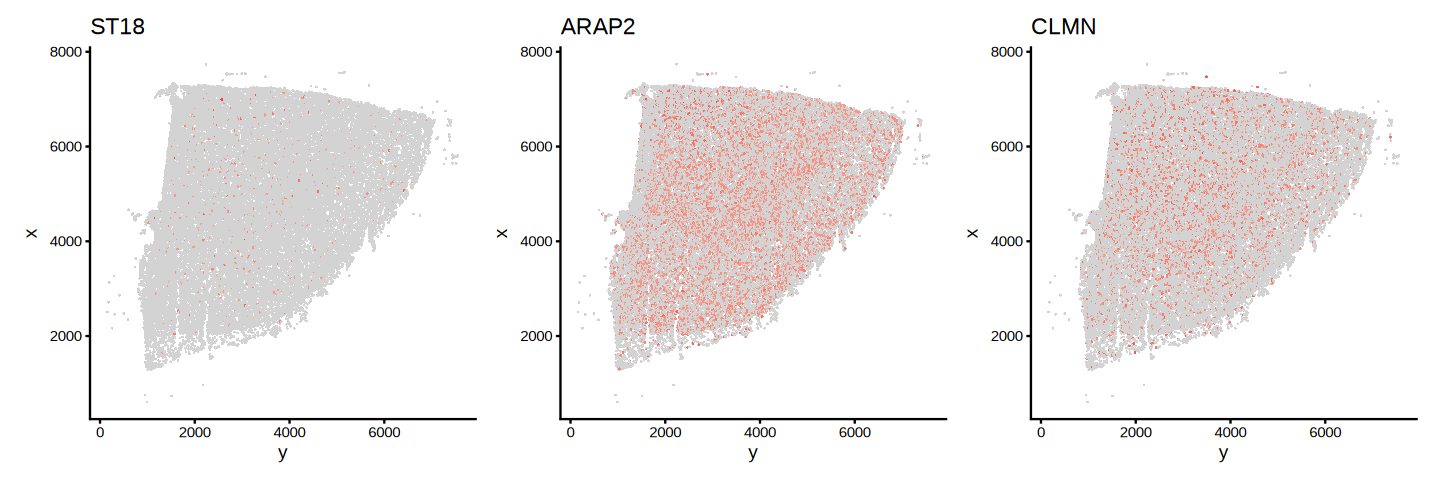

In [93]:
t1 <- ImageFeaturePlot(mmg, fov = "UCI5224Q06PSC2", features = c('ST18', 'ARAP2', 'CLMN'), axes = TRUE) & theme_classic() & NoLegend()
t2 <- ImageFeaturePlot(mmg, fov = "UCI2424Q02PSC1", features = c('ST18', 'ARAP2', 'CLMN'), axes = TRUE) & theme_classic() & NoLegend()

options(repr.plot.width = 12, repr.plot.height = 4)
t1
t2

## Read DPT spatial prediction

In [20]:
spalist <- read.csv("MiniAtlas_spatial_mapping_cca_quan_cortex_annotated.11.20.2025.csv", row.names = 1, header = T)
qclist <- read.csv("MiniAtlas_spatial_mapping_cca_score_quan_cortex_annotated.11.20.2025.csv", row.names = 1, header = T)
mmeta <- read.csv("quan_cortex_annotated_cca.11.20.2025.metadata.csv", header = T)

In [132]:
gscore1 <- read_h5ad("../04.clustering/01.DNA/MiniAtlas_H3K27ac_merged_dual_filt_clean_250722_cluster_manual_name_geneScore.h5ad")
gscore2 <- read_h5ad("../04.clustering/01.DNA/MiniAtlas_H3K27me3_merged_dual_filt_clean_250722_cluster_manual_name_geneScore.h5ad")

In [133]:
gscore1 <- CreateSeuratObject(t(gscore1$X), meta.data = gscore1$obs)
gscore1 <- NormalizeData(gscore1)
gscore2 <- CreateSeuratObject(t(gscore2$X), meta.data = gscore2$obs)
gscore2 <- NormalizeData(gscore2)

gscore1
gscore2

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts



An object of class Seurat 
60606 features across 339097 samples within 1 assay 
Active assay: RNA (60606 features, 0 variable features)
 2 layers present: counts, data

An object of class Seurat 
60606 features across 411980 samples within 1 assay 
Active assay: RNA (60606 features, 0 variable features)
 2 layers present: counts, data

In [134]:
acumap <- read.table("../04.clustering/01.DNA/MiniAtlas_H3K27ac_merged_dual_filt_clean_keep_250918_UMAP_cood_new.txt", sep = ",", header = T, row.names = 1) 
tmp <- acumap[,c("k27acumapnew_1", "k27acumapnew_2")] %>% setNames(c("UMAP1", "UMAP2")) %>% as.matrix
rownames(tmp) <- paste0(acumap$dna, ":", acumap$atac_bc)
gscore1[["UMAP"]] <- CreateDimReducObject(embeddings = tmp, key = "UMAP")

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP to UMAP_”


In [135]:
acumap <- read.table("../04.clustering/01.DNA/MiniAtlas_H3K27me3_merged_dual_filt_clean_keep_250918_UMAP_cood_new.txt", sep = ",", header = T, row.names = 1) 
tmp <- acumap[,c("k27me3umapnew_1", "k27me3umapnew_2")] %>% setNames(c("UMAP1", "UMAP2")) %>% as.matrix
rownames(tmp) <- paste0(acumap$dna, ":", acumap$atac_bc)

gscore2[["UMAP"]] <- CreateDimReducObject(embeddings = tmp, key = "UMAP")

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP to UMAP_”


## Plot side-by-side spatial prediction and MERFISH

In [21]:
f <- "UCI5224Q02PSC1"
qregion <- rmatch %>% filter(region == f) %>% select(br_region) %>% unlist %>% as.character
qmeta <- mmeta %>% filter(orig.ident == "Droplet Paired-Tag", region %in% qregion)
qcell <- qclist %>% filter(fov == f) %>% filter(purity_score >= 0.5) %>% select(cell_id) %>% unlist %>% as.character 

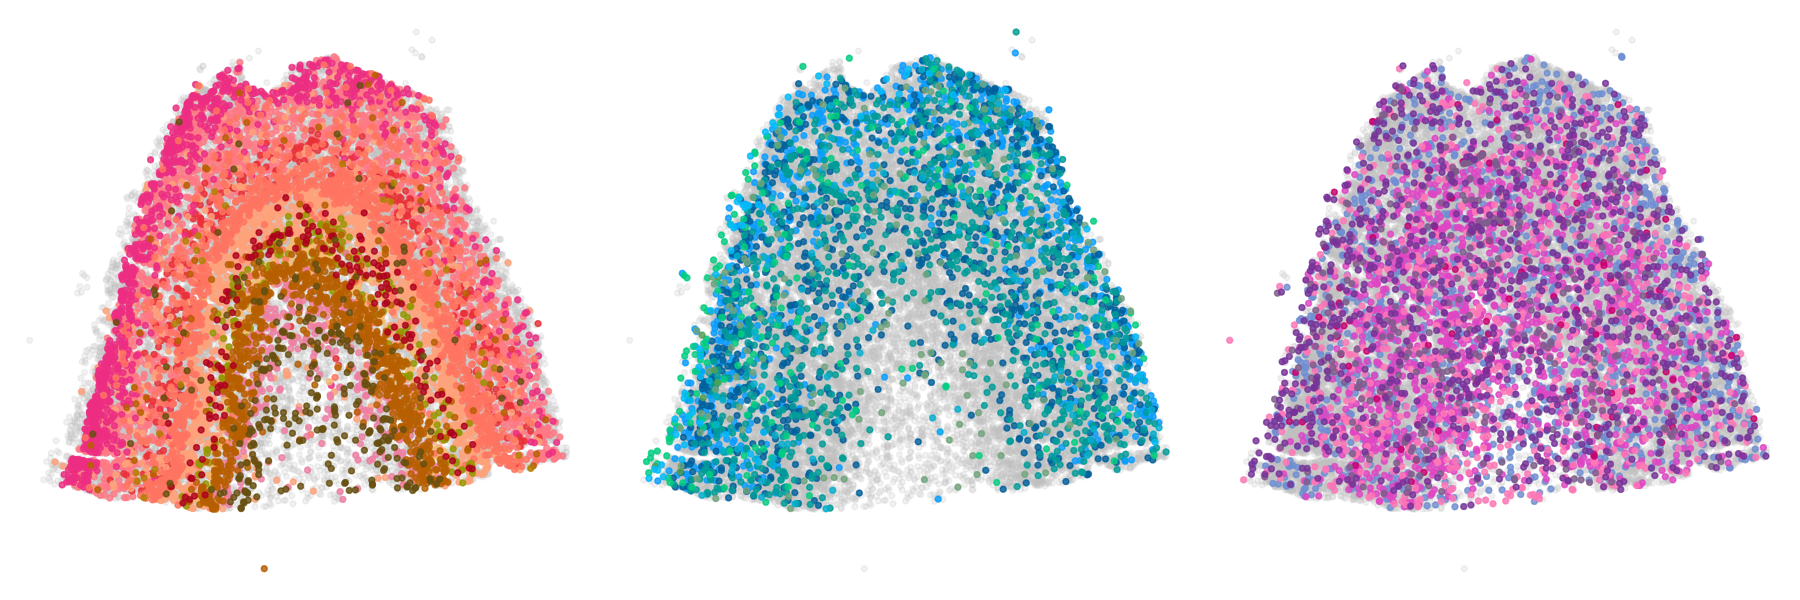

In [31]:
tmp <- mmg@meta.data %>% filter(!(X_CELLTYPE_CCA %in% c("low quality", "Low quality"))) %>%
filter(region == f)

### subsample: should not be balanced.
set.seed(921)

scell <- list()
for (ct in glut){
    sscell <- rownames(tmp[tmp$X_CELLTYPE_CCA %in% ct,])
    cap <- min(length(sscell), 1000)
    scell[[ct]] <- sample(sscell, size = max(ceiling(0.5*length(sscell)), cap), replace = F)
}
scell <- unlist(scell) %>% as.character

t1 <- tmp %>%
ggplot(aes(x = center_x, y = center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[scell, ], 
           aes(x = center_x, y = center_y, color = X_CELLTYPE_CCA), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

scell <- list()
for (ct in gaba){
    sscell <- rownames(tmp[tmp$X_CELLTYPE_CCA %in% ct,])
    cap <- min(length(sscell), 1000)
    scell[[ct]] <- sample(sscell, size = max(ceiling(0.5*length(sscell)), cap), replace = F)
}
scell <- unlist(scell) %>% as.character

t2 <- tmp %>%
ggplot(aes(x = center_x, y = center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[scell, ], 
           aes(x = center_x, y = center_y, color = X_CELLTYPE_CCA), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

scell <- list()
for (ct in nonn){
    sscell <- rownames(tmp[tmp$X_CELLTYPE_CCA %in% ct,])
    cap <- min(length(sscell), 1000)
    scell[[ct]] <- sample(sscell, size = max(ceiling(0.5*length(sscell)), cap), replace = F)
}
scell <- unlist(scell) %>% as.character

t3 <- tmp %>%
ggplot(aes(x = center_x, y = center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[scell, ], 
           aes(x = center_x, y = center_y, color = X_CELLTYPE_CCA), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 15, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
fig1

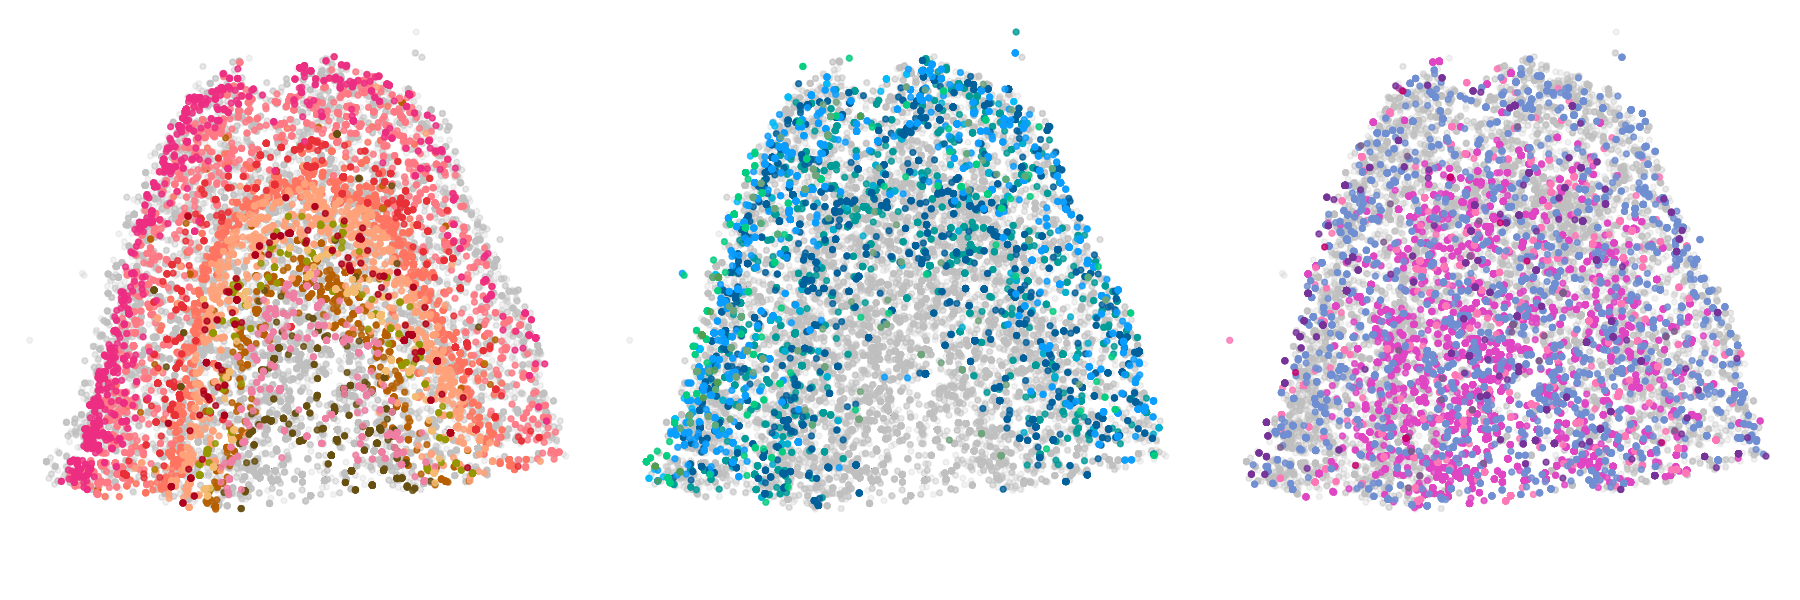

In [34]:
tmp <- spalist %>% filter(fov == f) %>% filter(cell_id %in% qcell)

t1 <- tmp %>%
ggplot(aes(x = pred_center_x, y = pred_center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[tmp$subclass %in% glut,], 
           aes(x = pred_center_x, y = pred_center_y, color = subclass), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

t2 <- tmp %>%
ggplot(aes(x = pred_center_x, y = pred_center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[tmp$subclass %in% gaba,], 
           aes(x = pred_center_x, y = pred_center_y, color = subclass), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

t3 <- tmp %>%
ggplot(aes(x = pred_center_x, y = pred_center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[tmp$subclass %in% nonn,], 
           aes(x = pred_center_x, y = pred_center_y, color = subclass), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
xlim(8500, 15600) + ylim(400, 7300) + 
scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 15, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
fig1

## Show marker gene on spatial plot

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



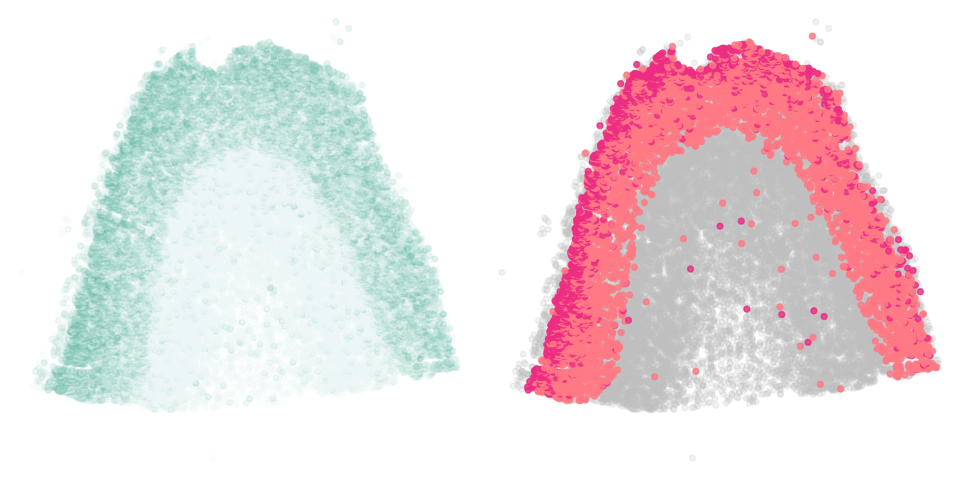

In [512]:
tmp <- mmg@meta.data %>% filter(!(X_CELLTYPE_CCA %in% c("low quality", "Low quality"))) %>%
filter(region == f)

t0 <- FeaturePlot(obj, "CUX2")
t0 <- merge(t0$data, tmp, by = 0) %>%
ggplot(aes(x = center_x, y = center_y, color = CUX2)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) +  
scale_color_gradientn(colours = c("#eff8f5", "#59b4a2"), limits = c(0, 2), oob = squish) + NoLegend()
# scale_colour_gradientn(limits = c(0, 3), colours = rev(brewer.pal(n = 11, name = "RdBu"))) + NoLegend()
# scale_color_distiller(direction = 1, limits = c(0, 2), oob = scales::squish)

t4 <- tmp %>%
ggplot(aes(x = center_x, y = center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[tmp$X_CELLTYPE_CCA %in% c("L2IT", "L23IT"),], 
           aes(x = center_x, y = center_y, color = X_CELLTYPE_CCA), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 8, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t0, t4, ncol = 2)
fig1

In [518]:
f <- "UCI5224Q02PSC1"
qregion <- rmatch %>% filter(region == f) %>% select(br_region) %>% unlist %>% as.character
qmeta <- mmeta %>% filter(orig.ident == "Droplet Paired-Tag", region %in% qregion)
qcell <- qclist %>% filter(fov == f) %>% filter(purity_score >= 0.5) %>% select(cell_id) %>% unlist %>% as.character 

tmp <- spalist %>% filter(fov == f) %>% filter(cell_id %in% qcell)
dim(tmp)

[1] 34670     6

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



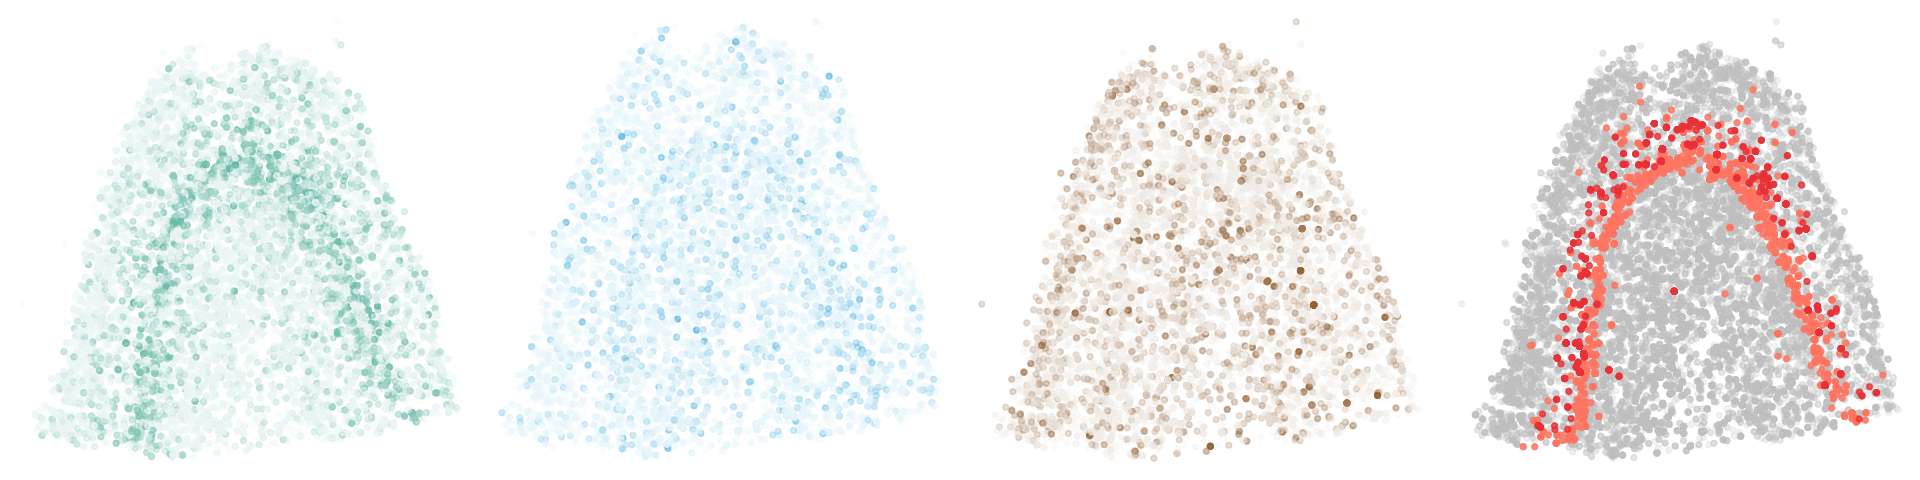

In [221]:
tmp <- spalist %>% filter(fov == f) %>% filter(cell_id %in% qcell)

t0 <- FeaturePlot(obj, "RORB")
t0 <- merge(t0$data, tmp, by.x = 0, by.y = "cell_id") %>%
ggplot(aes(x = pred_center_x, y = pred_center_y, color = RORB)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#eff8f5", "#59b4a2"), limits = c(0, 2), oob = squish) + NoLegend()

### H3K27ac gene score
t1 <- FeaturePlot(gscore1, "RORB", max.cutoff = "q90")
t1 <- merge(t1$data, tmp, by.x = 0, by.y = "dna_cell_id") %>%
ggplot(aes(x = pred_center_x, y = pred_center_y, color = RORB)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#eaf6fb", "#2EA7E0"), limits = c(0, 2), oob = squish) + NoLegend()

### H3K27me3 gene score
t2 <- FeaturePlot(gscore2, "RORB", max.cutoff = "q90")
t2 <- merge(t2$data, tmp, by.x = 0, by.y = "dna_cell_id") %>%
ggplot(aes(x = pred_center_x, y = pred_center_y, color = RORB)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#f4efea", "#956134"), limits = c(0, 2), oob = squish) + NoLegend()

t3 <- tmp %>%
ggplot(aes(x = pred_center_x, y = pred_center_y)) + 
geom_point(size = 1, color = "grey", alpha = 0.2) + 
geom_point(data = tmp[tmp$subclass %in% c("L35IT", "L45IT"),], 
           aes(x = pred_center_x, y = pred_center_y, color = subclass), 
           size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 16, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t0, t1, t2, t3, ncol = 4)
fig1

## Laminar distribution of SST

In [594]:
dmtx <- read.csv("DM/SST_MERFISH_MiniAtlas_integration.DC.csv", row.names = 1)
tmp <- read.csv("majortype/SST_MERFISH_MiniAtlas_integration.umap.csv", row.names = 1) %>%
filter(region %in% goodfov | orig.ident == "Droplet Paired-Tag")
merge(tmp, dmtx, by = 0) %>% select(subclass_corrected) %>% table
merge(tmp, dmtx, by = 0) %>% select(X_CELLTYPE_CCA) %>% table

subclass_corrected
  SST 
10403 

X_CELLTYPE_CCA
 SST 
4894 

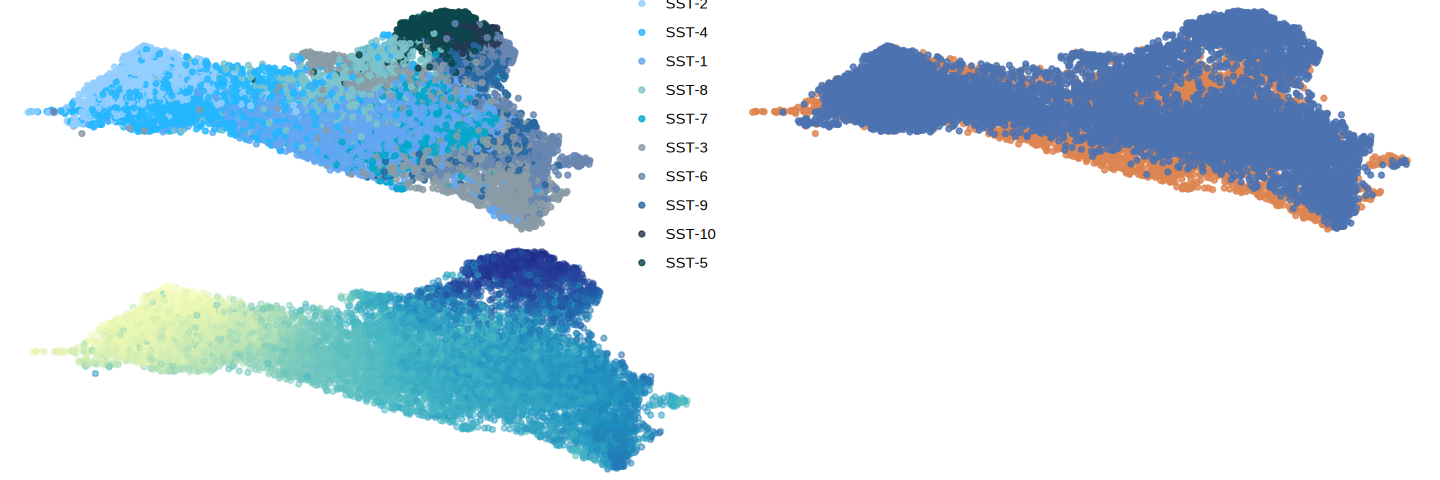

In [627]:
tcol <- c("#93ceff","#25b6ff","#63a6f1","#7dc3ca","#00a7ca","#8a9ba5","#6886b0","#2667a1","#25384f","#0a464b")

t0 <- merge(tmp, dmtx, by = 0) %>% # filter(orig.ident == "MERFISH") %>% 
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = nlabel)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_manual(values = tcol)

t1 <- merge(tmp, dmtx, by = 0) %>% 
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
ggplot(aes(x = umap_1, y = umap_2, color = orig.ident)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_colour_manual(values = c("#4C72B0", "#DD8452")) + 
NoLegend()

t2 <- merge(tmp, dmtx, by = 0) %>% 
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
ggplot(aes(x = umap_1, y = umap_2, color = V1)) + 
geom_point(size = 1, alpha = 0.5) + 
theme_void() + labs(title = NULL) + 
scale_colour_gradientn(limits = c(-0.02, 0.02), colours = brewer.pal(n = 9, name = "YlGnBu")) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 4)
fig2 <- cowplot::plot_grid(t0, t1, t2)
fig2

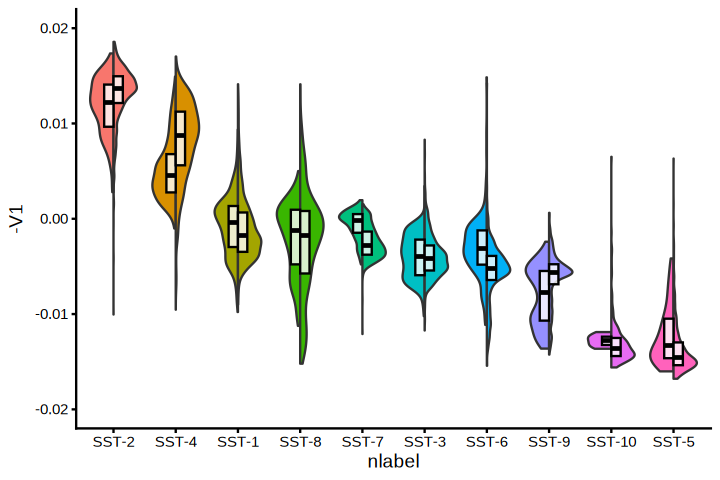

In [595]:
fig1 <- merge(tmp, dmtx, by = 0) %>% 
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% qorder) %>%
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
mutate(orig.ident = factor(orig.ident, levels = c("MERFISH", "Droplet Paired-Tag"))) %>%
ggplot(aes(x = nlabel, y = -V1, split = orig.ident)) + 
gghalves::geom_half_violin(aes(fill = nlabel), position = "identity", scale = "width") + 
geom_boxplot(width = 0.3, color="black", alpha=0.8, coef = 0, outlier.shape = NA, 
             fill = "white", position=position_dodge(0.3)) +
ylim(-0.02, 0.02) + 
theme_classic() + NoLegend() #+ scale_fill_manual(values = c("#4C72B0", "#DD8452"))

options(repr.plot.width = 6, repr.plot.height = 4)
fig1

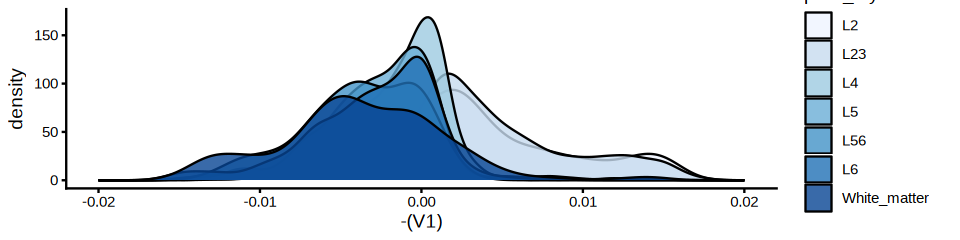

In [591]:
tcol <- c('#00395d','#004c7c','#00609b','#327faf','#0080ce','#008fe8','#669fc3','#7fafcd','#99bfd7','#ccdfeb')
fig1 <- merge(dmtx, obj@meta.data, by = 0) %>% 
filter(orig.ident == "MERFISH") %>% 
ggplot(aes(x = -(V1), fill = pred_layer)) + 
geom_density(color = "black", alpha = 0.8) + 
xlim(-0.02, 0.02) + 
theme_classic() + scale_fill_brewer()

options(repr.plot.width = 8, repr.plot.height = 2)
fig1

Warning message:
“Removed 351 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 233 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 169 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 149 rows containing missing values or values outside the scale range (`geom_point()`).”


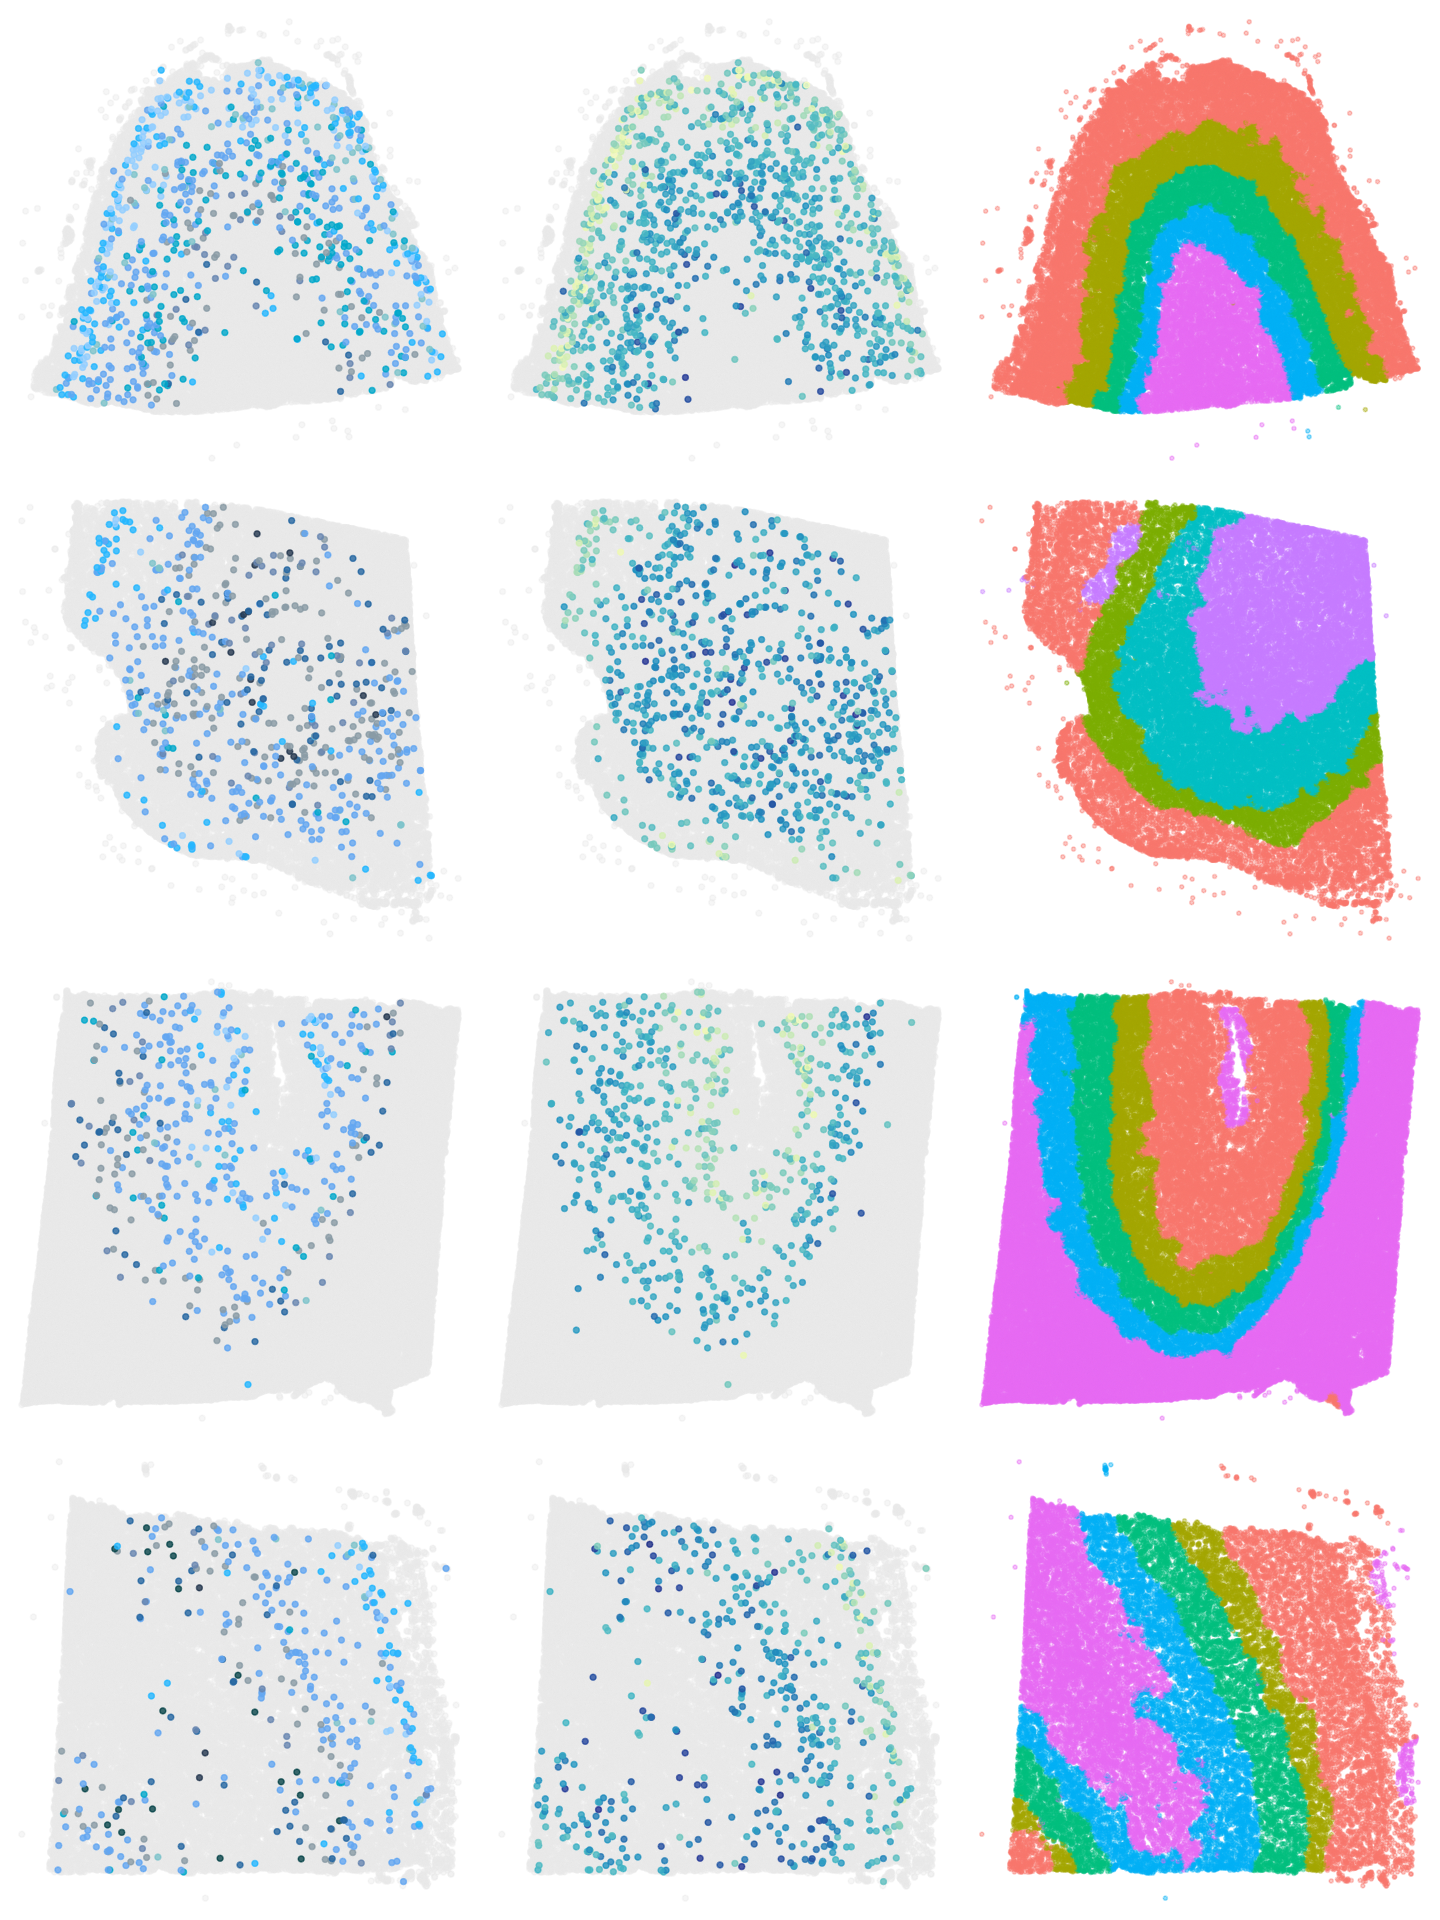

In [630]:
tcol <- c("#93ceff","#25b6ff","#63a6f1","#7dc3ca","#00a7ca","#8a9ba5","#6886b0","#2667a1","#25384f","#0a464b")

### Plot subtypes and pseudodepoth
plist <- list()
i <- 1
for (f in c("UCI5224Q02PSC1", "UWA7648Q02A38", "UWA7648Q04PPHC", "UCI5224Q06Ig")){
    qcell1 <- mmg@meta.data %>% filter(!(X_CELLTYPE_CCA %in% c("low quality", "Low quality"))) %>% filter(region == f) %>% rownames
    qcell1 <- intersect(qcell1, rownames(dmtx))
    qcell2 <- qclist %>% filter(fov == f) %>% filter(purity_score >= 0.5) %>% select(cell_id) %>% unlist %>% as.character 
    qcell2 <- intersect(qcell2, rownames(dmtx))
    dtp <- merge(tmp, dmtx[c(qcell1, qcell2), ], by = 0) %>% tibble::column_to_rownames("Row.names")
    
    df <- spalist %>% filter(fov == f) %>% filter(cell_id %in% qcell2)
    rownames(df) <- df$cell_id
    dtp[qcell2, c('center_x', 'center_y')] <- df[qcell2, c('pred_center_x', 'pred_center_y')]

    dtp$nlabel <- NA
    dtp[qcell1, ]$nlabel <- dtp[qcell1, ]$X_SUBTYPE_CCA
    dtp[qcell2, ]$nlabel <- dtp[qcell2, ]$cluster_manual_name
    dtp <- dtp %>% mutate(nlabel = factor(nlabel, levels = qorder))

    plist[[paste0(f, ":cluster_manual")]] <- mmg@meta.data %>% filter(region == f) %>%
    ggplot(aes(x = center_x, y = center_y)) + 
    geom_point(size = 1, color = "#e8e8e8", alpha = 0.4) + 
    geom_point(data = dtp[dtp$orig.ident == "MERFISH" & dtp$nlabel != "low quality",], 
               aes(x = center_x, y = center_y, color = nlabel), 
               size = 1, alpha = 0.8) + 
    theme_void() + labs(title = NULL) + scale_color_manual(values = tcol) + NoLegend()

    plist[[paste0(f, ":DC")]] <- mmg@meta.data %>% filter(region == f) %>%
    ggplot(aes(x = center_x, y = center_y)) + 
    geom_point(size = 1, color = "#e8e8e8", alpha = 0.4) + 
    geom_point(data = dtp[dtp$orig.ident == "MERFISH",], 
               aes(x = center_x, y = center_y, color = V1), 
               size = 1, alpha = 0.8) + 
    theme_void() + labs(title = NULL) + 
    scale_colour_gradientn(limits = c(-0.02, 0.02), colours = brewer.pal(n = 9, name = "YlGnBu")) + NoLegend()

    plist[[paste0(f, ":layer")]] <- mmg@meta.data %>% filter(region == f) %>%
    ggplot(aes(x = center_x, y = center_y, color = pred_layer)) + 
    geom_point(size = 0.5, alpha = 0.4) + 
    theme_void() + labs(title = NULL) + NoLegend()
    
    i = i + 1
}

options(repr.plot.width = 12, repr.plot.height = 16)
fig1 <- cowplot::plot_grid(plotlist = plist, ncol = 3)
fig1

In [351]:
### Plot heatmaps of some DE genes along laminar axis
expr1 <- ArcXPM(obj[["RNA"]]$counts.1, meta = obj@meta.data, method = "RPKM", group.by = "cluster_manual_name", 
               gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")

qcell <- obj@meta.data %>% filter(orig.ident == "MERFISH", !is.na(X_SUBTYPE_CCA)) %>% rownames
expr2 <- ArcXPM(obj[["RNA"]]$counts.2[,qcell], meta = obj@meta.data[qcell, ], 
                method = "RPKM", group.by = "X_SUBTYPE_CCA", 
                gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")

sparsity: 0.892233757990661
coarse dgTMatrix into Matrix.
check readSums:  115 
check obj_mtx_collapse:  115 


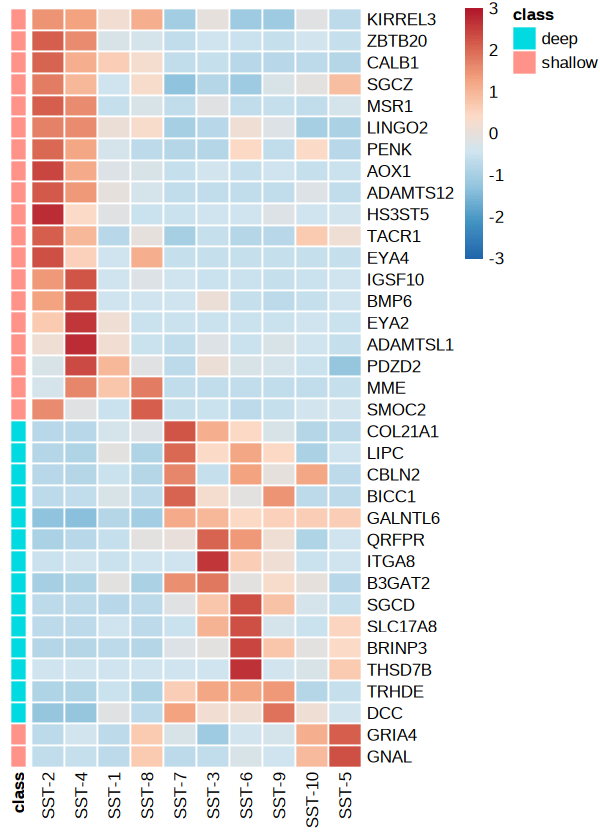

In [534]:
# https://www.nature.com/articles/s41467-025-62793-9/figures/5
qgene1 <- c("KIRREL3", "ZBTB20", "CALB1", "SGCZ", "MSR1", "IGSF10", "BMP6", "SEMA3D",
"MME", "LINGO2", "EYA2", "ADAMTSL1", "PENK", "AOX1", "ADAMTS12", "HS3ST5",
"PDZD2", "TACR1", "NPY", "SMOC2", "EYA4", "GRIA4", "GNAL")
qgene2 <- c("GRIN3A", "COL21A1", "FGD3", "SGCD", "SLC17A8", "TRHDE", "QRFPR", "ITGA8", "BRINP3",
"THSD7B", "LIPC", "CBLN2", "CYP26A1", "BICC1", "DCC", "GALNTL6",
"B3GAT2", "EDNRA", "HTR1F", "RELN", "GRAMD2B", "SYT9", "STK32A", "ZNF488")

### threshold again with DE genes
qgene <- deg2 %>% filter(FDR < 0.01) %>% rownames
qgene <- intersect(c(qgene1, qgene2), qgene)

ranno <- data.frame(gene = c(qgene1, qgene2), class = c(rep("shallow", times = length(qgene1)), rep("deep", times = length(qgene2)))) %>%
tibble::column_to_rownames("gene")

options(repr.plot.width = 5, repr.plot.height = 7)
rmat <- log2(expr1[intersect(qgene, rownames(expr1)), qorder] + 1)
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
fig1 <- rmat[permutation_vector, ] %>%
pheatmap(cluster_col = F, cluster_row = F, treeheight_row = F, scale = "row", 
         annotation_row = ranno, breaks = seq(-3, 3, 0.06), 
         border_color = "white", show_rownames = T, angle_col = 90, 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

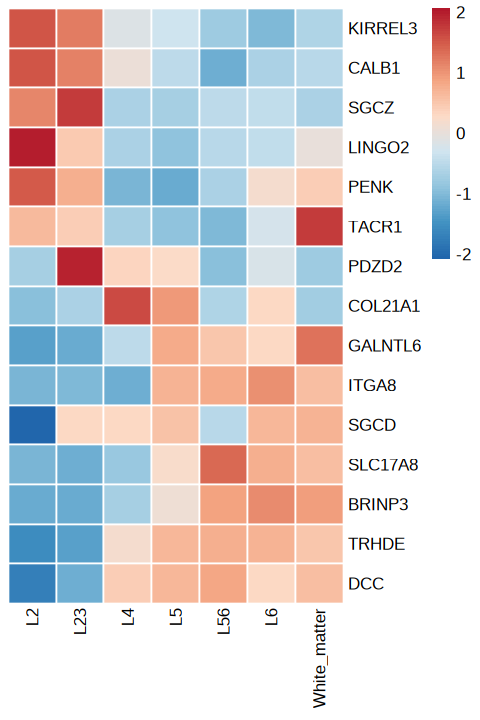

In [404]:
### validate with MERFISH
options(repr.plot.width = 4, repr.plot.height = 6)
rmat2 <- log2(expr3[intersect(rownames(rmat[permutation_vector, ]), rownames(expr3)), sort(colnames(expr3))] + 1)
rmat2 %>%
pheatmap(cluster_col = F, cluster_row = F, treeheight_row = F, scale = "row", 
         border_color = "white", show_rownames = T, angle_col = 90, 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

## Run diff analysis with continous variable (1st DC)

In [161]:
### OK use pseudoreplicates for edgeR
qmeta <- merge(mmg@meta.data, dmtx, by = 0) %>% tibble::column_to_rownames("Row.names")
make_pseudogroups <- function(n, t) {
  rep(seq_len(t), length.out = n)
}

n <- nrow(qmeta)
qmeta$pdonor <- make_pseudogroups(n, t = 2)

In [162]:
system("mkdir -p DM/edgeR")
tmp <- subset(mmg, cells = rownames(qmeta))
tmp@meta.data <- qmeta[colnames(tmp), ]
exprr <- AggregateExpression(tmp, group.by = c("pdonor", "depth_bin"))
designs = stringr::str_split_fixed(colnames(exprr$Spatial), n = 2, pattern = "_") %>% 
as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$Spatial)

designs$group <- as.numeric(designs$group)
edgeR_ovr_pairwise(exprr$Spatial, sample = designs, group = "group", pairwise = FALSE, prefix = "DM/edgeR/SST_DC1", mode = "continuous")

Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not v

In [163]:
deg <- read.table("DM/edgeR/SST_DC1_edgeR_group_continuous.tsv")

deg %>% filter(FDR < 0.05) %>%
slice_max(order_by = logFC, n = 3)

deg %>% filter(FDR < 0.05) %>%
slice_min(order_by = logFC, n = 5)

logFC     logCPM    F         PValue       FDR         
TRHDE   0.5450771 12.284893  78.48129 3.660851e-08 8.834212e-07
GALNTL6 0.4862187  7.840997 172.68509 6.096253e-11 7.986092e-09
TAC3    0.4834482 10.285188  98.53548 6.115514e-09 2.336636e-07

logFC      logCPM    F         PValue       FDR         
PENK  -0.8405768 10.387925  73.29554 6.214311e-08 1.292814e-06
SGCZ  -0.6027050  9.795964  24.24994 9.500775e-05 4.786929e-04
LAMP5 -0.5745612  9.169150 109.69061 2.577396e-09 1.243933e-07
CUX2  -0.5616418 11.605475 208.44093 1.128444e-11 2.244861e-09
CBLN4 -0.5030055 11.657266 105.02742 3.653805e-09 1.595495e-07

In [164]:
## Now calculate for DPT
qmeta <- merge(obj@meta.data, dmtx, by = 0) %>% tibble::column_to_rownames("Row.names") %>% filter(orig.ident == "Droplet Paired-Tag")
tmp <- subset(obj, cells = rownames(qmeta))
tmp$depth_bin <- qmeta[colnames(tmp), ]$depth_bin
exprr <- AggregateExpression(tmp, group.by = c("donor", "depth_bin"))
designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% 
as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$RNA)

designs$group <- as.numeric(designs$group)
edgeR_ovr_pairwise(exprr$RNA, sample = designs, group = "group", 
                   pairwise = FALSE, prefix = "DM/edgeR/SST_DPT_DC1", mode = "continuous")

Checking sample order matches counts columns...

Creating DGEList...

Running continuous variable test...

Done.



In [177]:
deg2 <- read.table("DM/edgeR/SST_DPT_DC1_edgeR_group_continuous.tsv")

deg2 %>% filter(FDR < 0.05) %>%
slice_max(order_by = logFC, n = 5)

deg2 %>% filter(FDR < 0.05) %>%
slice_min(order_by = logFC, n = 5)

logFC    logCPM   F         PValue       FDR         
NPFFR2          2.600514 2.482459  87.37094 8.611136e-08 2.568101e-06
MEPE            2.490517 2.451950 101.92814 2.085068e-08 8.150065e-07
ENSG00000225588 2.338471 1.411846 119.85883 3.939153e-08 1.365418e-06
WNT16           2.128507 3.128947  58.73279 9.728922e-07 2.186330e-05
LINC01789       1.940791 1.413328  88.50707 2.557501e-08 9.655590e-07

logFC     logCPM   F        PValue       FDR         
DRD3      -1.372386 1.988811 179.2388 3.548071e-14 9.807768e-12
LINC01687 -1.309260 4.452224  78.7728 1.944487e-10 1.480732e-08
LINC00308 -1.195557 1.423330 120.9594 4.080939e-12 5.040131e-10
FRMD7     -1.176120 1.490962 176.2473 8.018397e-15 2.916853e-12
DSP       -1.107064 2.200336 220.2889 6.542117e-19 1.922990e-15

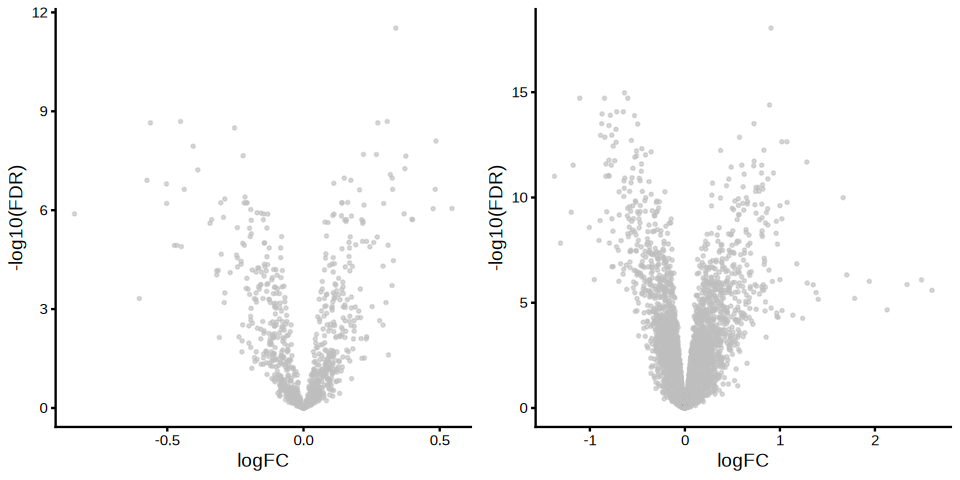

In [170]:
### Compare
t1 <- deg %>%
ggplot(aes(x = logFC, y = -log10(FDR))) +
geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
theme_classic()

t2 <- deg2 %>%
ggplot(aes(x = logFC, y = -log10(FDR))) +
geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
theme_classic()

options(repr.plot.width = 8, repr.plot.height = 4)
cowplot::plot_grid(t1, t2)

[1] 0.5233815


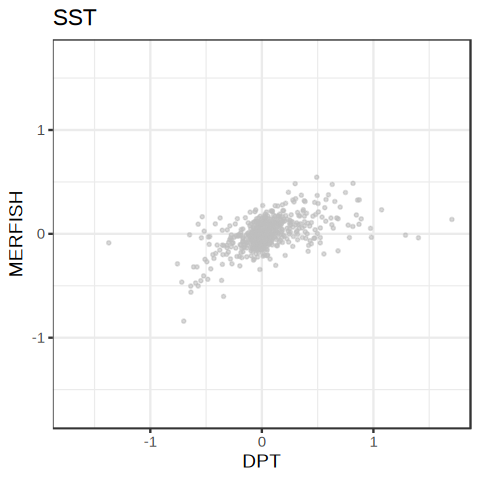

In [172]:
df <- merge(deg, deg2, by = 0) # %>% filter(p_val_adj.x < 0.05 | p_val_adj.y < 0.05)
print(cor(df$logFC.x, df$logFC.y))
qmax <- max(c(abs(df$logFC.x), abs(df$logFC.y)))

options(repr.plot.width = 4, repr.plot.height = 4)
df %>%
ggplot(aes(x = logFC.y, y = logFC.x)) + 
geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
xlab("DPT") + ylab("MERFISH") + ggtitle("SST") + 
theme_bw() + 
xlim(-qmax, qmax) + ylim(-qmax, qmax)

## Perform H3K27me3 diff test for gene score 

In [662]:
set.seed(921)
qmeta <- merge(gscore2@meta.data %>% tibble::rownames_to_column("dna_bc"), dmtx, by.x = "rna_bc", by.y = 0) %>%
tibble::column_to_rownames("dna_bc")
make_pseudogroups <- function(n, t) {
  rep(seq_len(t), length.out = n)
}

n <- nrow(qmeta)
qmeta$pdonor <- make_pseudogroups(n, t = 2)
table(qmeta$pdonor, qmeta$depth_bin)

   
      1   2   3   4   5   6   7   8
  1 471 356 157 192 343 381 324 365
  2 462 336 175 198 302 391 355 370

In [663]:
### Do H3K27me3!!
tmp <- subset(gscore2, cells = rownames(qmeta))

tmp@meta.data <- qmeta[colnames(tmp), ]
exprr <- AggregateExpression(tmp, group.by = c("pdonor", "depth_bin"))
designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% 
as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$RNA)

designs$group <- as.numeric(designs$group)
edgeR_ovr_pairwise(exprr$RNA, sample = designs, group = "group", pairwise = FALSE, prefix = "DM/edgeR/SST_DC1_H3K27me3_genescore", mode = "continuous")

Checking sample order matches counts columns...

Creating DGEList...

Running continuous variable test...

Done.



In [681]:
### make a continous one
edgeR_ovr_pairwise(exprr$RNA, sample = designs, group = "group", pairwise = FALSE, prefix = "DM/edgeR/SST_DC1_H3K27me3_genescore", mode = "group")

Checking sample order matches counts columns...

Creating DGEList...

Running one-vs-rest contrasts...

Done.



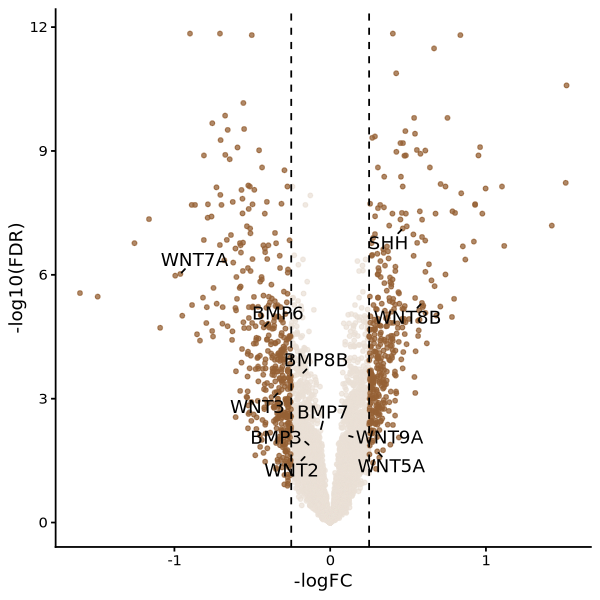

In [27]:
deg <- read.table("DM/edgeR/SST_DC1_H3K27me3_genescore_edgeR_group_continuous.tsv")

glabel <- c("SHH","WNT2","WNT3","WNT5A","WNT7A","WNT8B","WNT9A","BMP3","BMP6","BMP7","BMP8B")

options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- deg %>%
ggplot(aes(x = -logFC, y = -log10(FDR))) + 
geom_point(alpha = 0.7, size = 1, color = "#e9dfd6") + 
geom_point(data = deg[abs(deg$logFC) >= 0.25, ], 
           aes(x = -logFC, y = -log10(FDR)), 
           alpha = 0.7, size = 1, color = "#956134") + 
ggrepel::geom_text_repel(data = deg[glabel,] %>% tibble::rownames_to_column("gene"),
                         aes(x = -logFC, y = -log10(FDR), label = gene), 
                         min.segment.length = unit(0, "lines")) + 
geom_vline(xintercept = c(-0.25, 0.25), linetype = 2) + 
theme_classic()

options(repr.plot.width = 5, repr.plot.height = 5)
t1

In [691]:
### DC1 bin: 1 == superficial, 8 == deep
deg1 <- read.table("DM/edgeR/SST_DC1_H3K27me3_genescore_edgeR_1_vs_all.tsv")
deg1 %>% filter(FDR < 0.05) %>%
slice_max(order_by = logFC, n = 3)

deg2 <- read.table("DM/edgeR/SST_DC1_H3K27me3_genescore_edgeR_8_vs_all.tsv")
deg2 %>% filter(FDR < 0.05) %>%
slice_max(order_by = logFC, n = 3)

logFC    logCPM   F        PValue       FDR         
ENSG00000260261 6.193877 6.298609 435.2969 2.827537e-90 4.317084e-87
SDHAP1          5.796898 5.298800 158.2767 2.156180e-35 2.887768e-33
SDHAP2          5.513774 4.989044 104.2667 4.436161e-24 2.418975e-22

logFC    logCPM   F         PValue       FDR         
ARVCF  5.981553 4.870997 114.76019 2.694001e-26 1.996699e-24
CDH3   5.438328 4.642649  75.13837 7.120965e-18 2.651778e-16
MAN1A1 5.208650 5.745126 246.12542 3.032793e-53 7.983566e-51

In [704]:
dgene <- deg2 %>% filter(FDR < 0.05, logCPM >= 5) %>% filter(logFC >= 1) %>% rownames
ugene <- deg1 %>% filter(FDR < 0.05, logCPM >= 5) %>% filter(logFC >= 1) %>% rownames ### upper with H27me3
length(dgene); length(ugene)

qlist <- list()
i = 1
for (qgene in list(ugene, dgene)){ 
    qtable <- clusterProfiler::enrichGO(gene = qgene,
                OrgDb = org.Hs.eg.db::org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # molecule function
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
    qlist[[i]] <- qtable2@result %>% mutate(group = c("upper", "deep")[i]) 
    i = i + 1
}
lapply(qlist, nrow)

[1] 690

[1] 639

[[1]]
[1] 27

[[2]]
[1] 107

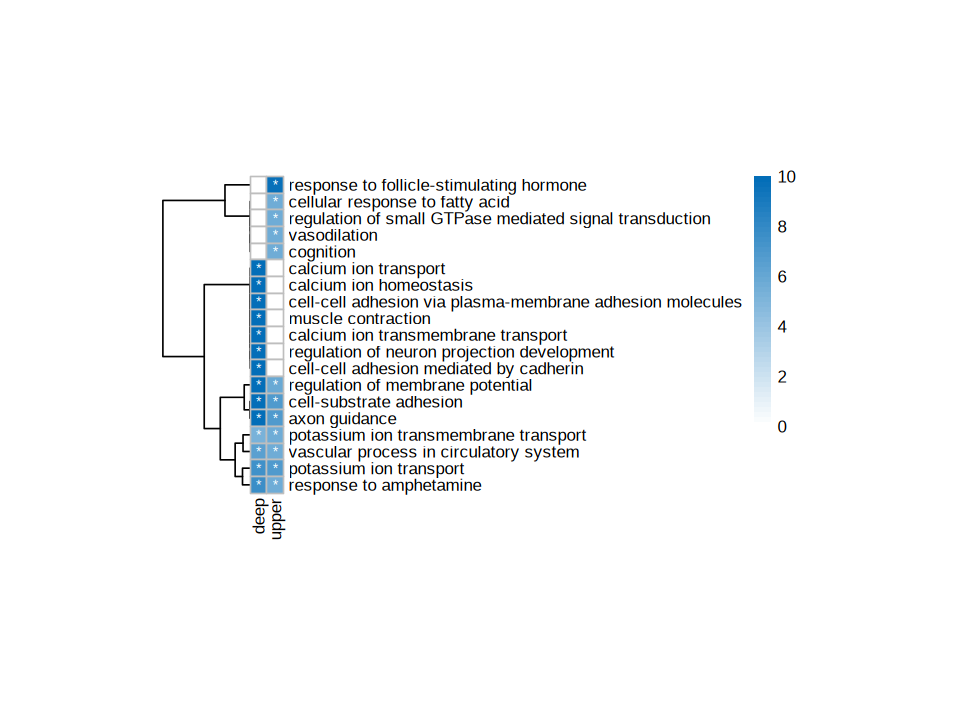

In [705]:
qterm1 <- do.call(rbind, qlist) %>%
group_by(group) %>%
filter(p.adjust < 0.05, Count >= 5, Count <= 500) %>%
slice_max(order_by = -log10(p.adjust), n = 10) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

tmp <- do.call(rbind, qlist) %>% 
reshape2::dcast(Description ~ group, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, ])
ttp1[ttp1 > 10] <- 10

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

options(repr.plot.width = 8, repr.plot.height = 6)
t2 <- ttp1 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10, breaks = seq(0, 10, 0.2),
         display_numbers = lmat1[rownames(ttp1), ], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(50))

In [718]:
### Plot gene score and also shown on spatial...
qgene1 <- stringr::str_split(qlist[[1]][qlist[[1]]$ID == "GO:0007411", "geneID"], "\\/")[[1]]
qgene2 <- stringr::str_split(qlist[[2]][qlist[[1]]$ID == "GO:0007411", "geneID"], "\\/")[[1]]
axong <- list('upper' = qgene1, 'deeper' = qgene2)

In [757]:
gscore1 <- AddModuleScore(gscore1, features = axong)
gscore2 <- AddModuleScore(gscore2, features = axong)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



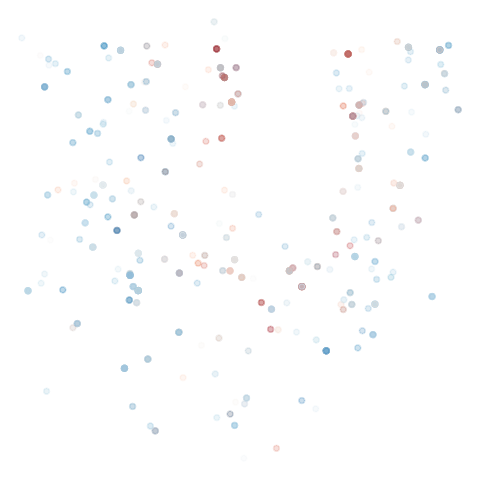

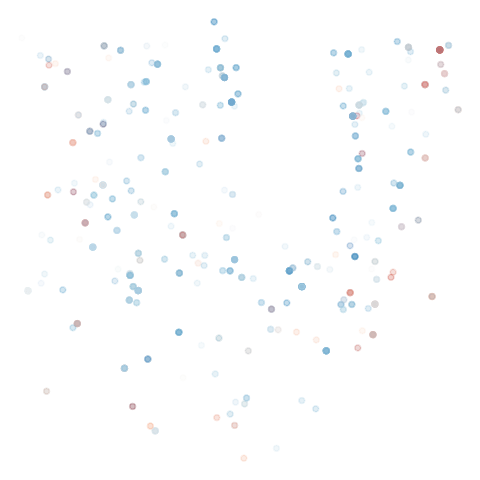

In [746]:
f <- "UWA7648Q04PPHC"
qregion <- rmatch %>% filter(region == f) %>% select(br_region) %>% unlist %>% as.character
qmeta <- mmeta %>% filter(orig.ident == "Droplet Paired-Tag", region %in% qregion)
qcell <- qclist %>% filter(fov == f) %>% filter(purity_score >= 0.5) %>% select(cell_id) %>% unlist %>% as.character 
tmp <- spalist %>% filter(fov == f) %>% filter(cell_id %in% qcell)

t2 <- FeaturePlot(gscore2, "Cluster1")
t2 <- merge(t2$data, tmp, by.x = 0, by.y = "dna_cell_id") %>%
filter(subclass == "SST") %>%
ggplot(aes(x = pred_center_x, y = pred_center_y, color = Cluster1)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) + 
scale_colour_gradientn(limits = c(-0.5, 0.5), colours = rev(brewer.pal(n = 11, name = "RdBu")), oob = squish) + NoLegend()

options(repr.plot.width = 4, repr.plot.height = 4)
t2

t3 <- FeaturePlot(gscore2, "Cluster2")
t3 <- merge(t3$data, tmp, by.x = 0, by.y = "dna_cell_id") %>%
filter(subclass == "SST") %>%
ggplot(aes(x = pred_center_x, y = pred_center_y, color = Cluster2)) + 
geom_point(size = 1, alpha = 0.2) + 
theme_void() + labs(title = NULL) + 
scale_colour_gradientn(limits = c(-0.5, 0.5), colours = rev(brewer.pal(n = 11, name = "RdBu")), oob = squish) + NoLegend()
t3

### so few!!

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



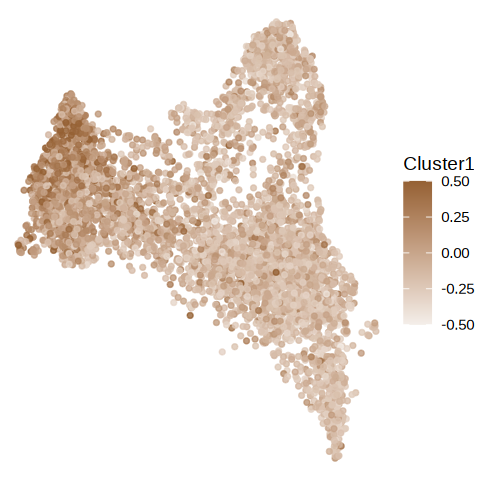

In [754]:
### Plot on UMAP instead...
tmp <- read.csv("majortype/SST_MERFISH_MiniAtlas_integration.umap.csv", row.names = 1) %>%
filter(region %in% goodfov | orig.ident == "Droplet Paired-Tag")
tmp$dna_bc <- paste0(tmp$dna, ":", tmp$atac_bc)

t2 <- FeaturePlot(gscore2, "Cluster1")
t0 <- merge(tmp, t2$data, by.x = "dna_bc", by.y = 0) %>%  
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = Cluster1)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#f4efea", "#956134"), limits = c(-0.5, 0.5), oob = squish)

t0

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



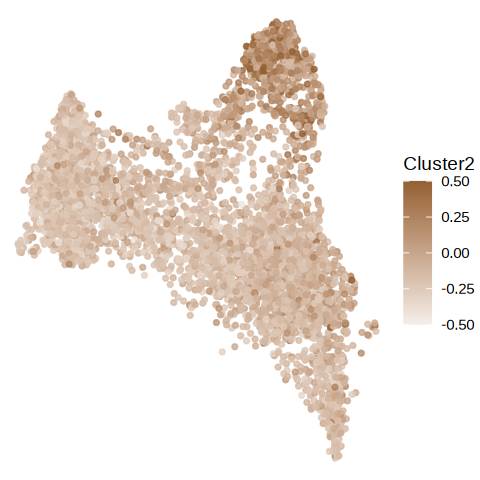

In [755]:
t2 <- FeaturePlot(gscore2, "Cluster2")
t1 <- merge(tmp, t2$data, by.x = "dna_bc", by.y = 0) %>%  
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = Cluster2)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#f4efea", "#956134"), limits = c(-0.5, 0.5), oob = squish)

t1

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



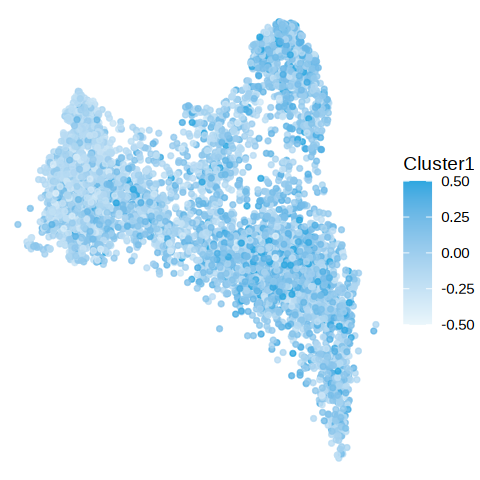

In [758]:
t2 <- FeaturePlot(gscore1, "Cluster1")
t2 <- merge(tmp, t2$data, by.x = "dna_bc", by.y = 0) %>%  
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = Cluster1)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#eaf6fb", "#2EA7E0"), limits = c(-0.5, 0.5), oob = squish)

t2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



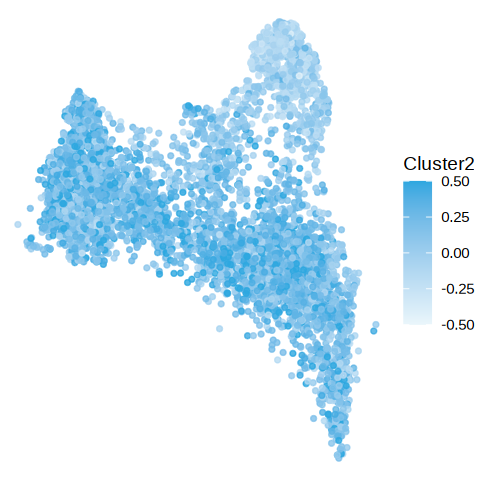

In [759]:
t2 <- FeaturePlot(gscore1, "Cluster2")
t3 <- merge(tmp, t2$data, by.x = "dna_bc", by.y = 0) %>%  
mutate(nlabel = ifelse(orig.ident == "MERFISH", X_SUBTYPE_CCA, cluster_manual_name)) %>%
filter(nlabel %in% paste0("SST-", 1:10)) %>% 
filter(!is.na(nlabel)) %>% 
mutate(nlabel = factor(nlabel, levels = qorder)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = Cluster2)) + 
geom_point(size = 1, alpha = 0.8) + 
theme_void() + labs(title = NULL) + 
scale_color_gradientn(colours = c("#eaf6fb", "#2EA7E0"), limits = c(-0.5, 0.5), oob = squish)

t3

In [331]:
system("mkdir -p layer_DE/DEgene/")
set.seed(921)
for (f in c("SST", "PVALB")){
    qcell1 <- mresult %>% filter(cell_type == f) %>% select(cell_id, layer_group) %>% distinct %>% tibble::column_to_rownames('cell_id')
    tmp <- subset(obj, cells = rownames(qcell1))
    tmp$layer_group <- qcell1[colnames(tmp),]
    
    DefaultAssay(tmp) <- "RNA"
    qcell1 <- tmp@meta.data %>% filter(layer_group == 'upper') %>% rownames
    qcell2 <- tmp@meta.data %>% filter(layer_group == 'deep') %>% rownames
    exprr <- AggregateExpression(tmp, group.by = c("donor", "layer_group"), assay = "RNA")
    designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% as.data.frame %>% setNames(c("sample", "group"))
    rownames(designs) <- colnames(exprr$RNA)
    edgeR_ovr_pairwise(exprr$RNA, sample = designs, group = "group", pairwise = T,
              prefix = paste0("layer_DE/DEgene/", f, "_"))

}

Checking sample order matches counts columns...

Creating DGEList...

Running one-vs-rest contrasts...

Running pairwise contrasts...

Done.

Checking sample order matches counts columns...

Creating DGEList...

Running one-vs-rest contrasts...

Running pairwise contrasts...

Done.



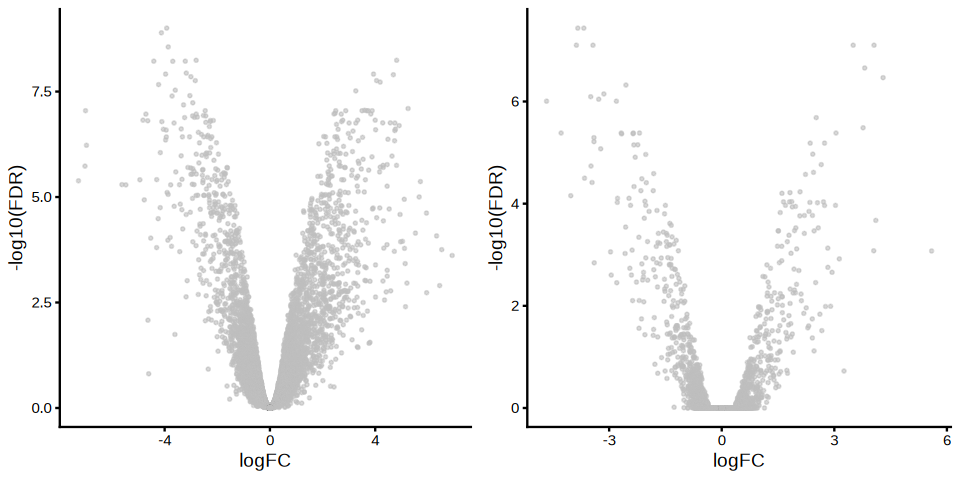

In [12]:
t1 <- read.table("layer_DE/DEgene/SST__edgeR_deep_vs_upper.tsv") %>%
ggplot(aes(x = logFC, y = -log10(FDR))) +
geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
theme_classic()

t2 <- read.table("layer_DE/DEgene/PVALB__edgeR_deep_vs_upper.tsv") %>%
ggplot(aes(x = logFC, y = -log10(FDR))) +
geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
theme_classic()

options(repr.plot.width = 8, repr.plot.height = 4)
cowplot::plot_grid(t1, t2)

[1] 0.5562911
[1] 0.5632915


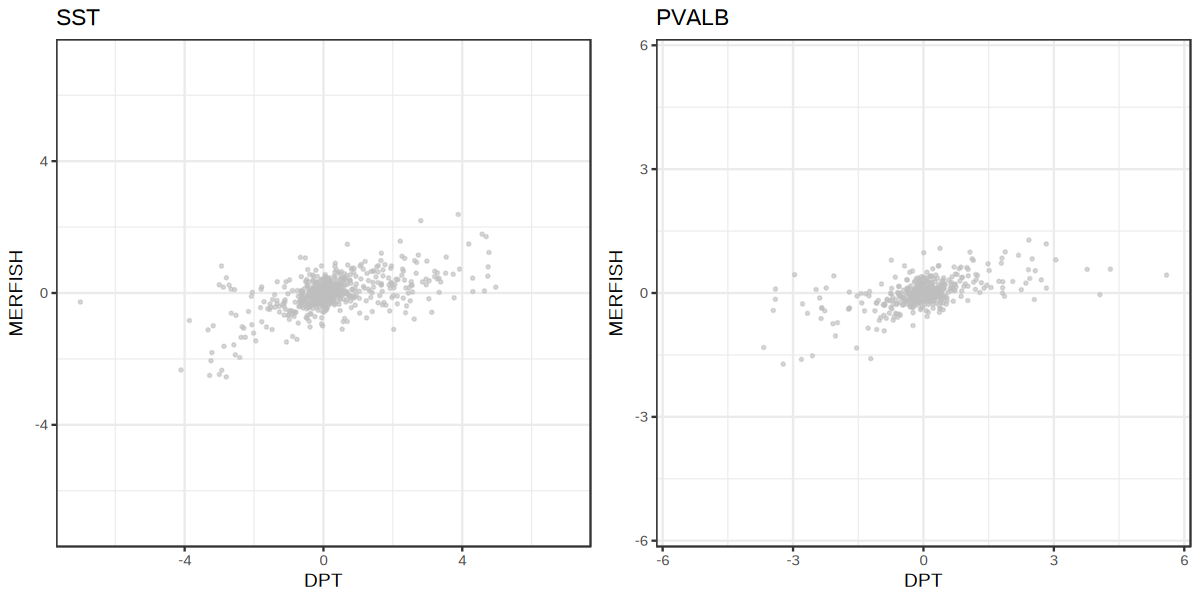

In [13]:
### compare
plist <- list()
for (f in c("SST", "PVALB")){
    d1 <- read.table(paste0("layer_DE/DEgene/", f, "__edgeR_deep_vs_upper.tsv")) 
    d2 <- read.table(paste0("layer_DE/MERFISH/DEgene/", f, "__edgeR_deep_vs_upper.tsv")) 
    df <- merge(d1, d2, by = 0) # %>% filter(p_val_adj.x < 0.05 | p_val_adj.y < 0.05)
    print(cor(df$logFC.x, df$logFC.y))
    qmax <- max(c(abs(df$logFC.x), abs(df$logFC.y)))
    plist[[f]] <- df %>%
    ggplot(aes(x = logFC.x, y = logFC.y)) + 
    geom_point(size = 0.5, alpha = 0.6, color = "grey") + 
    xlab("DPT") + ylab("MERFISH") + ggtitle(f) + 
    theme_bw() + 
    xlim(-qmax, qmax) + ylim(-qmax, qmax)
}

options(repr.plot.width = 10, repr.plot.height = 5)
cowplot::plot_grid(plotlist = plist, ncol = 2)